In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import datetime as dt
import time
import awkward as ak
import uproot
from tqdm import tqdm
from glob import glob
from scipy import stats as st
from scipy import signal
import numba as nb

import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

import re

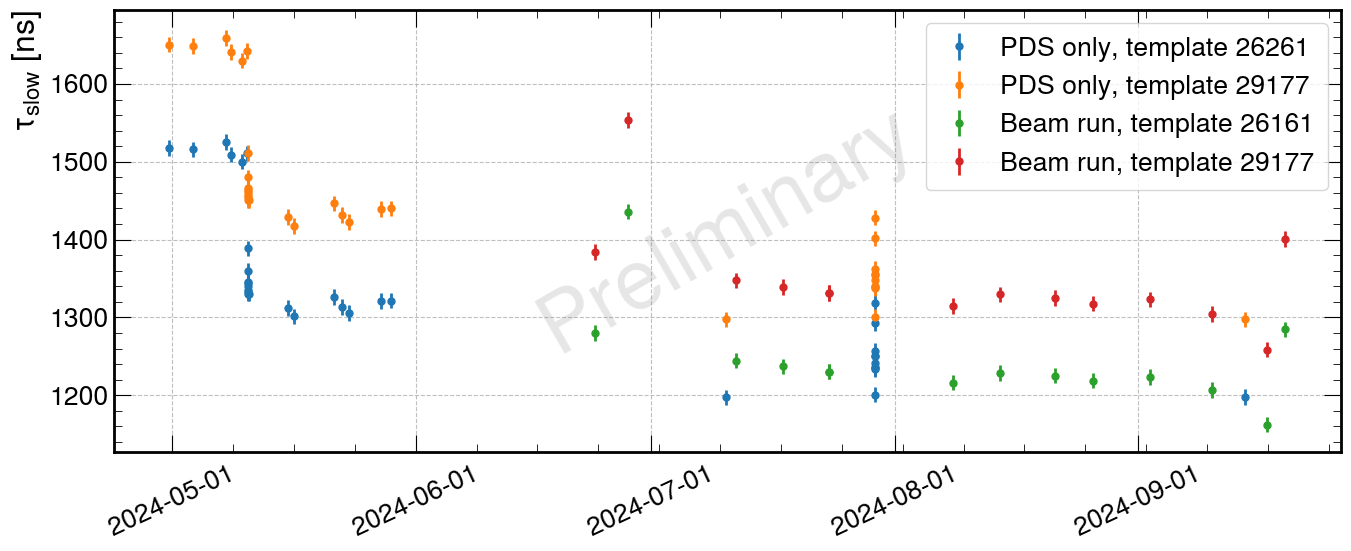

In [23]:
def read_conv_data(folder = "./results_fixtemplate" ):
    
    files = sorted(glob(f"{folder}/run0*/convolution_output*.txt"))


    dtp = np.dtype([
        ("timestamp", np.uint64),
        ("A_f", np.float32),
        ("tau_f", np.float32 ),
        ("tau_s", np.float32 ),
        ("Efield", np.float32 ),
        ("run", np.int16 ),
        ("time", np.object_ ),
        ("chi2", np.float32 ),
        ("nwvf", np.int64 ),
    ])

    data = np.zeros(len(files), dtype=dtp)
    runs = []
    for i, file in enumerate(files):
        tmp = np.fromfile(file, sep=' ')
        p = re.compile('[0-9]+')
        runnumber = file.strip(f'{folder}/run0')
        runnumber = (int(p.match(runnumber).group(0)))
        runs.append(runnumber)

        data[i]['timestamp'] = tmp[0]*16e-9
        data[i]['A_f'] = tmp[1]
        data[i]['tau_f'] = tmp[2]
        data[i]['tau_s'] = tmp[3]
        data[i]['Efield'] = -100
        data[i]['run'] = runnumber
        data[i]['time'] = dt.datetime.fromtimestamp(tmp[0]*16e-9)
        data[i]['chi2'] = tmp[4]
        data[i]['nwvf'] = tmp[5]

    return data

def preliminary(ax, x=0.5, y=0.5):
    ax.text(x, y, 'Preliminary', transform=ax.transAxes,
            fontsize=60, color='gray', alpha=0.2,
            ha='center', va='center', rotation=30)

plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = mdate.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
    
# data = read_conv_data("./results_fixtemplate/")
datafix = read_conv_data("./results_norm_accept_next_bigger_shift_fixtemplate/")
datafix2 = read_conv_data("./results_norm_accept_next_bigger_shift_new_template_fixtemplate/")
datafixm = read_conv_data("./results_norm_accept_next_bigger_shift_new_template_fixtemplate_/")
databeam = read_conv_data("./results_beam_accept_next_bigger_shift_fixtemplate/")
databeam2 = read_conv_data("./results_beam_accept_next_bigger_shift_new_template_fixtemplate/")
skipp = None
endp = None
# plt.errorbar(data['time'][skipp:endp], data["tau_s"][skipp:endp], yerr=10, fmt='.', linewidth=2, markersize=10, label='Between 120 and 180 p.e.')
plt.errorbar(datafix['time'][skipp:endp], datafix["tau_s"][skipp:endp], yerr=10, fmt='.', linewidth=2, markersize=10, label='PDS only, template 26261')
plt.errorbar(datafix2['time'][skipp:endp], datafix2["tau_s"][skipp:endp], yerr=10, fmt='.', linewidth=2, markersize=10, label='PDS only, template 29177')
plt.errorbar(databeam['time'][skipp:endp], databeam["tau_s"][skipp:endp], yerr=10, fmt='.', linewidth=2, markersize=10, label='Beam run, template 26161')
plt.errorbar(databeam2['time'][skipp:endp], databeam2["tau_s"][skipp:endp], yerr=10, fmt='.', linewidth=2, markersize=10, label='Beam run, template 29177')
plt.ylabel(r'$\tau_{slow}$ [ns]')
preliminary(ax)
plt.legend(loc='best',frameon=True)
plt.savefig('tau_vs_time.png', dpi=200)

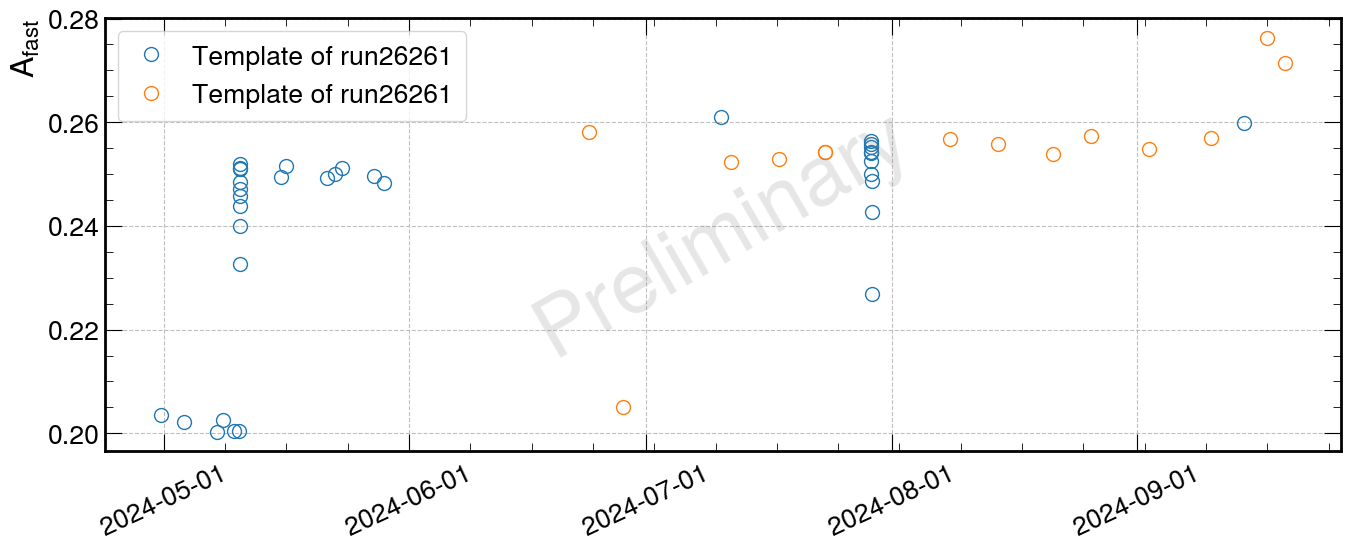

In [25]:
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = mdate.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
# plt.errorbar(data['time'][skipp:endp], data["A_f"][skipp:endp], yerr=0, fmt='.', linewidth=2, markersize=10, label='Template by run')
plt.plot(datafix['time'][skipp:endp], datafix["A_f"][skipp:endp], 'o', mfc='none', linewidth=2, markersize=10, label='Template of run26261')
plt.plot(databeam['time'][skipp:endp], databeam["A_f"][skipp:endp], 'o', mfc='none', linewidth=2, markersize=10, label='Template of run26261')
plt.ylabel(r'$A_{fast}$')
preliminary(ax)
plt.legend(frameon=True)

In [64]:
files_plot_resuls = sorted(glob("./run*/conv_fit.png"))
nfiles:int = len(files_plot_resuls)
print(files_plot_resuls)

['./run025171/conv_fit.png', './run025474/conv_fit.png', './run026084/conv_fit.png', './run026116/conv_fit.png', './run026141/conv_fit.png', './run026145/conv_fit.png', './run026147/conv_fit.png', './run026149/conv_fit.png', './run026152/conv_fit.png', './run026154/conv_fit.png', './run026161/conv_fit.png', './run026163/conv_fit.png', './run026165/conv_fit.png', './run026167/conv_fit.png', './run026254/conv_fit.png', './run026265/conv_fit.png']


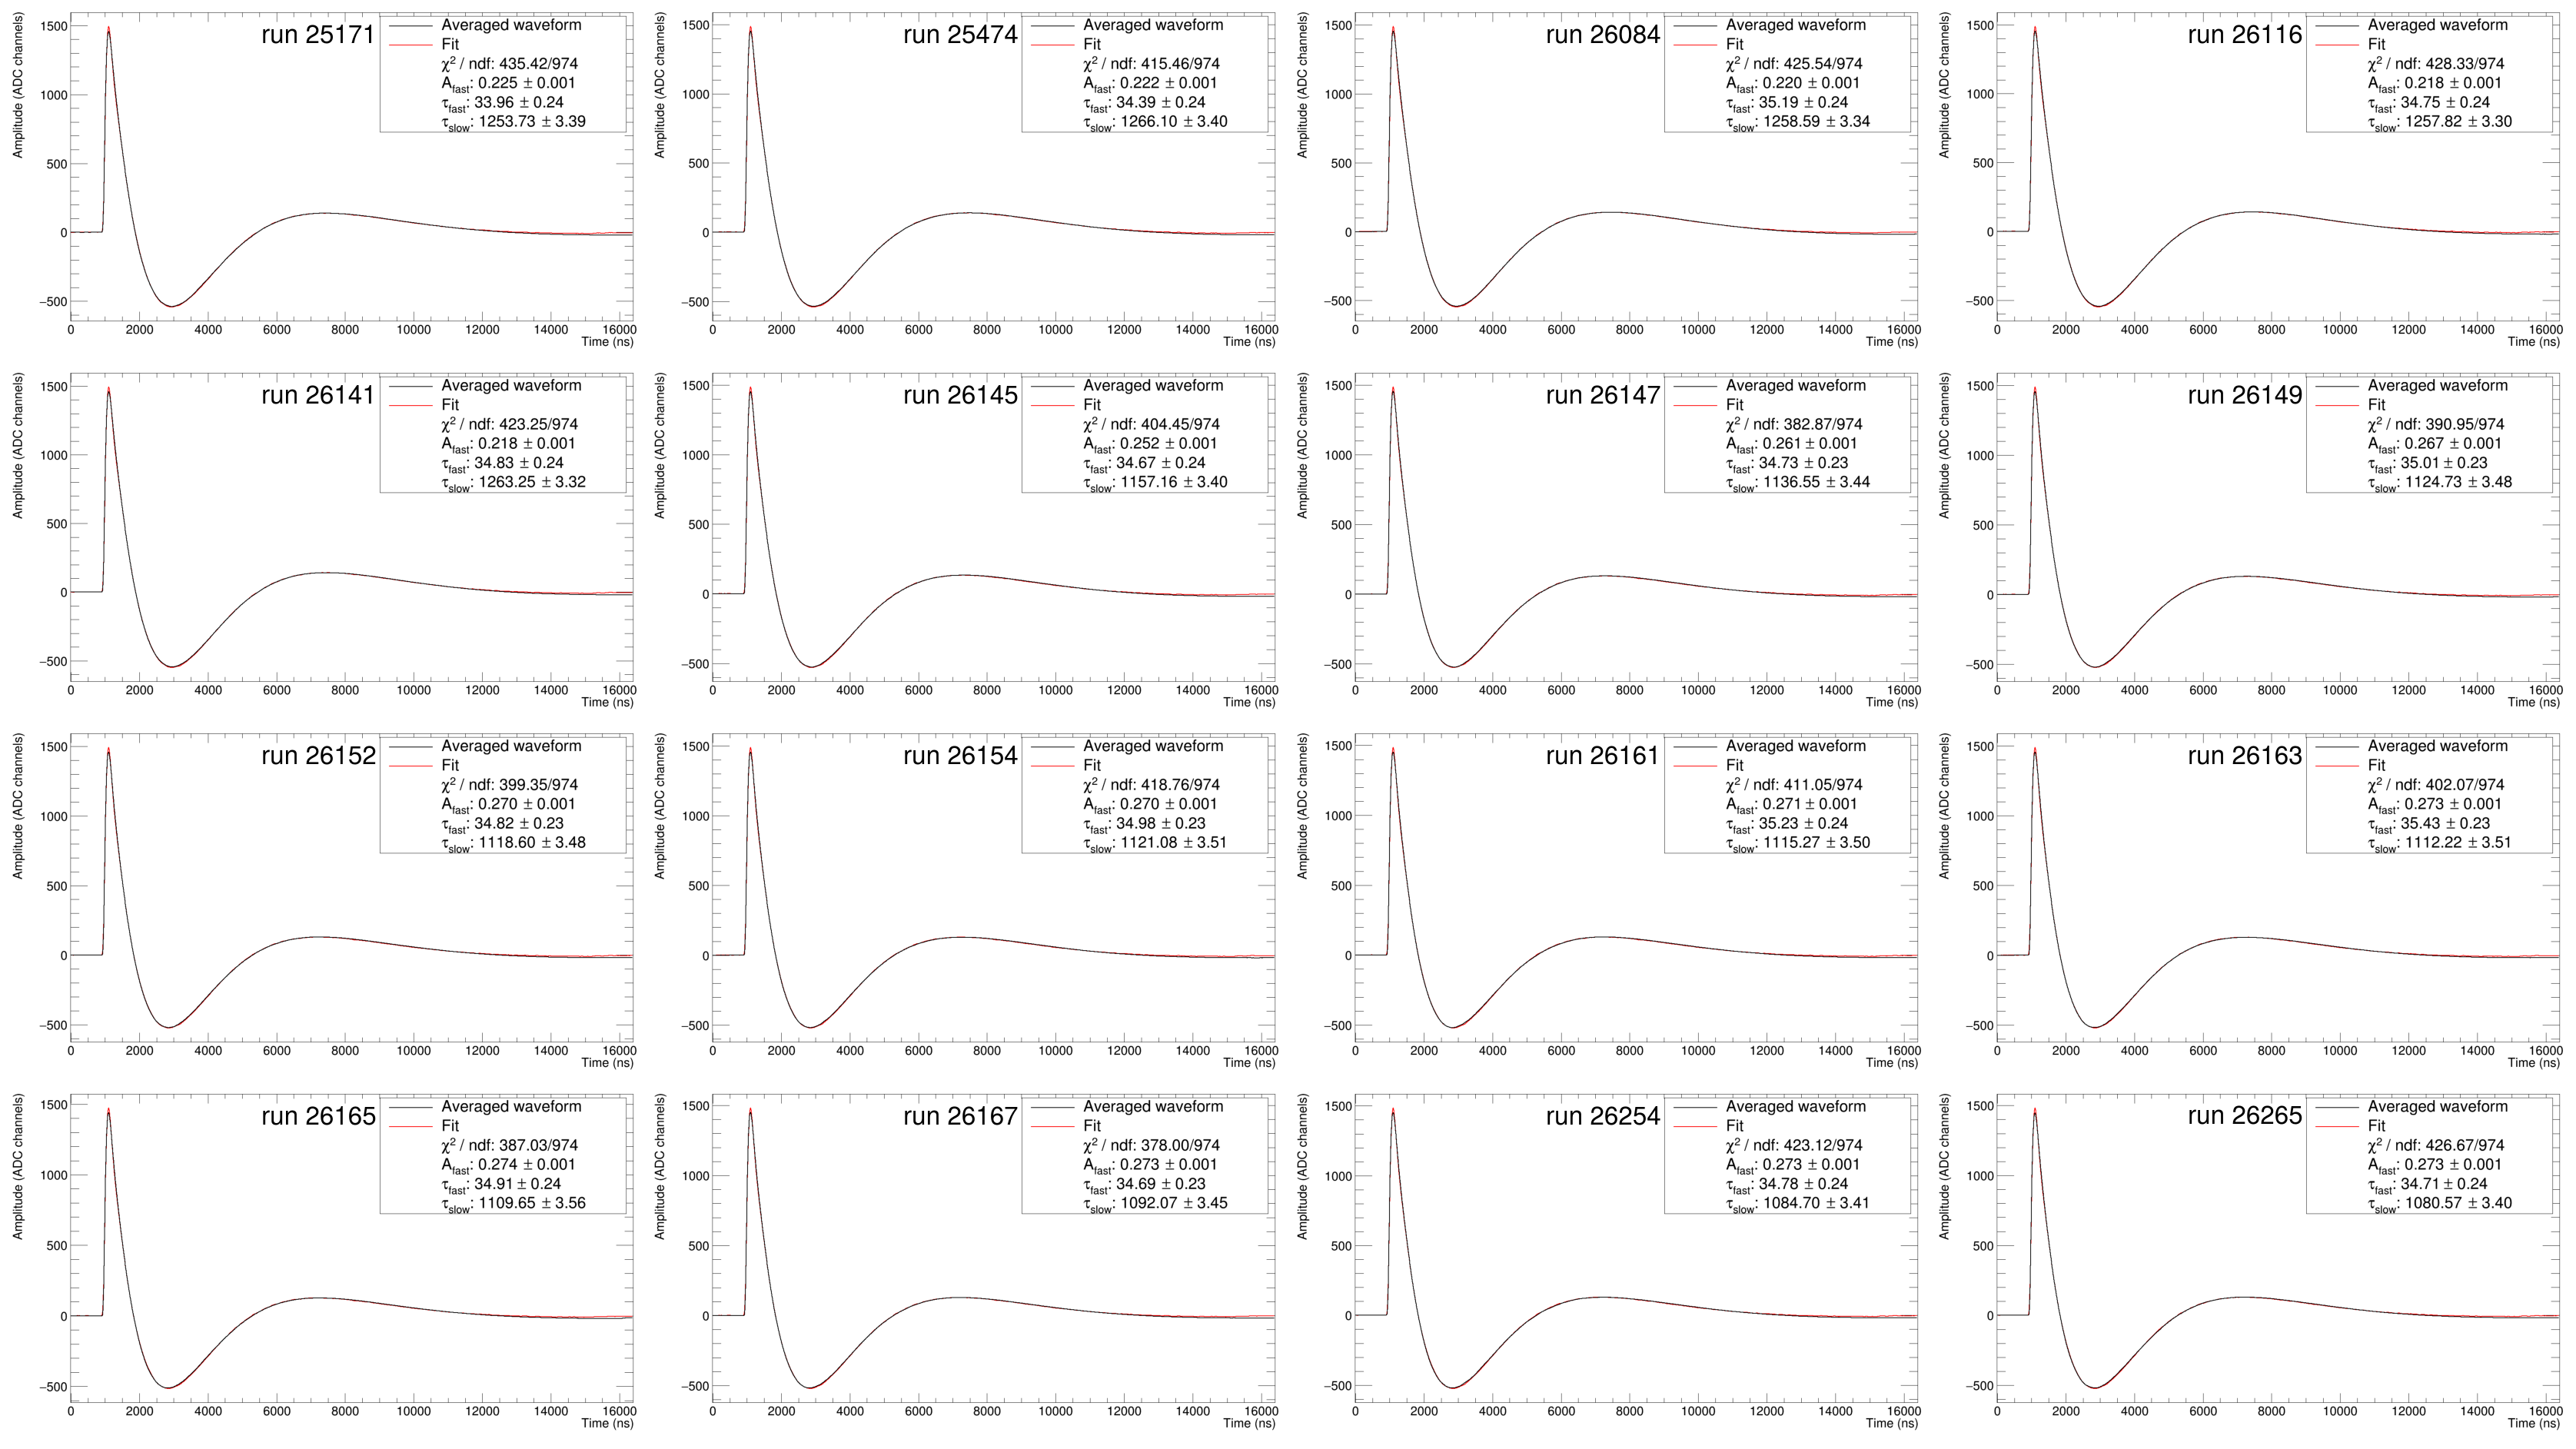

/tmp/ipykernel_3745434/1503176438.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('all_results.pdf', dpi=300, bbox_inches='tight')


In [78]:
from mpl_toolkits.axes_grid1 import ImageGrid
import re

fig = plt.figure(figsize=(34, 34.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, files_plot_resuls):
    ax:plt.Axes
    result = plt.imread(im)
    result = result[90:, 20:1750,:]
    p = re.compile('./run0(.+)/conv_')
    m = p.match(im)
    r = f"run {m.group(1)}"
    ax.imshow(result)
    ax.text(0.4,0.9,r, transform=ax.transAxes, fontsize=24)
    ax.axis('off')

plt.show()
fig.savefig('all_results.pdf', dpi=300, bbox_inches='tight')
